# EDA of Bluesky feed samples

Here’s what we’ll compare:

- **How big each sample is:** total posts and how many different people show up in each feed.
- **What languages people are posting in:** based on the `langs` tag attached to each post.
- **How long posts tend to be:** estimated with a rough **word count** from `text`.
- **How much engagement posts get:** average likes/reposts/replies, plus how often those numbers are just zero.
- **How reply-heavy the feed is:** what fraction of posts are replies (i.e., `reply_to` is filled in).
- **How activity changes over time:** daily posting volume for each feed.

In [77]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [78]:
def load_jsonl_gz_fixed(path):
    import gzip, json, pandas as pd

    rows = []
    with gzip.open(path, "rt", encoding="utf-8") as f:
        for line in f:
            rows.append(json.loads(line))

    df = pd.DataFrame(rows)

    if "date" in df.columns:
        df["date"] = pd.to_datetime(
            df["date"].astype(str),
            format="%Y%m%d%H%M",
            errors="coerce"
        )

    return df

## Quick sanity check on one file

Before loading everything, we read a single gzipped JSONL file (`News.jsonl.gz`) just to confirm:

- the parser works on the real data format, and  
- the `date` field looks sensible (we immediately check min/max).


In [79]:
df_test = load_jsonl_gz_fixed("feed_posts/News.jsonl.gz")
df_test["date"].min(), df_test["date"].max()

(Timestamp('2023-02-20 02:27:00'), Timestamp('2024-03-18 23:41:00'))

## Data ingestion and schema

Each feed lives in `feed_posts/` as a gzipped JSONL file. We load each file into a DataFrame, add a `feed` column
(from the filename), and then concatenate everything into one table (`df_all`).

Key columns used in the EDA below:

- `feed`: which feed this post came from (derived from the file name).
- `date`: timestamp of the post (used for min/max and any time grouping).
- `user_id`: author identifier (used for “unique users” counts).
- `langs`: list of language tags detected for the post (can be multiple).
- `text`: post text (used to build an approximate word count).
- `like_count`, `repost_count`, `reply_count`: engagement counters.
- `reply_to`: present if the post is a reply (used to flag reply posts).

In [80]:
dfs = []

for file in os.listdir("feed_posts"):
    if file.endswith(".jsonl.gz"):
        tmp = load_jsonl_gz_fixed(f"feed_posts/{file}")
        tmp["feed"] = file.replace(".jsonl.gz", "")
        dfs.append(tmp)

df_all = pd.concat(dfs, ignore_index=True)

/var/folders/xg/gdrq_vp93cj1ps_x39psl1_00000gn/T/ipykernel_42612/1655135726.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(dfs, ignore_index=True)


### Time coverage in the combined dataset

Right after building `df_all`, we check the **earliest and latest** timestamps present.  
This is a basic guardrail: everything that follows (daily activity, “recent” vs “older” posts, etc.) depends on what time window we actually sampled.


In [81]:
df_all["date"].min(), df_all["date"].max()

(Timestamp('2023-02-20 02:27:00'), Timestamp('2024-03-18 23:59:00'))

## Posts per feed in this sample

First, we count how many posts we have from each feed (`df_all["feed"].value_counts()`).

In this dataset, the post counts are:

Blacksky: 86,490, News: 42,112, Science: 33,831, #UkrainianView: 2,098, AcademicSky: 913, GreenSky: 662, BookSky: 638, Game Dev: 635, #Disability: 566, Political Science: 357, What's History: 161

This is just sample size context: bigger feeds give smoother averages and distributions, while very small feeds can look “weird” simply due to low N.


In [82]:
df_all["feed"].value_counts()

feed
Blacksky             86490
News                 42112
Science              33831
#UkrainianView        2098
AcademicSky            913
GreenSky               662
BookSky                638
Game Dev               635
#Disability            566
Political Science      357
What's History         161
Name: count, dtype: int64

## Posts and unique users (per feed)

Here we compute two related summaries:

1) **Posts per feed** (already counted above).  
2) **Unique users per feed** (`nunique(user_id)`), which tells us whether a feed is “many posts from few accounts” or “many accounts contributing”.

We then visualize the post counts as a quick bar chart.

In [83]:
posts_per_feed = df_all["feed"].value_counts()

users_per_feed = (
    df_all.groupby("feed")["user_id"]
    .nunique()
    .sort_values(ascending=False)
)

### Post count comparison (bar chart)

This figure is the same information as the table above, just visualized: **number of posts per feed**.

(For reference, the largest feeds here are Blacksky (86,490), News (42,112), and Science (33,831).)


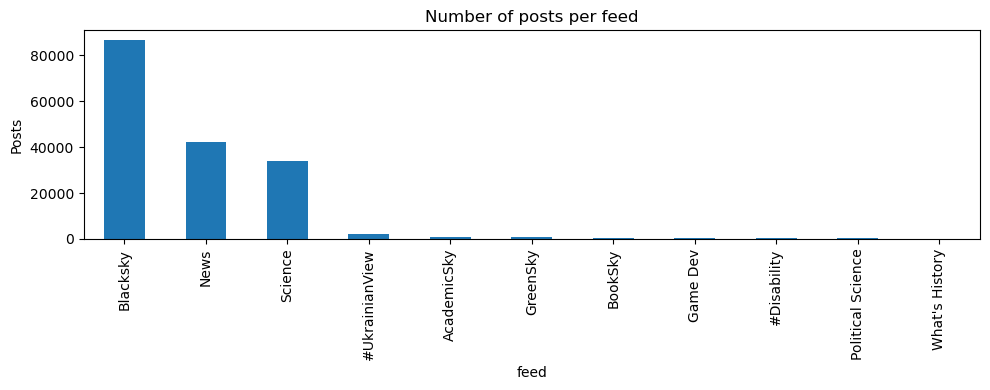

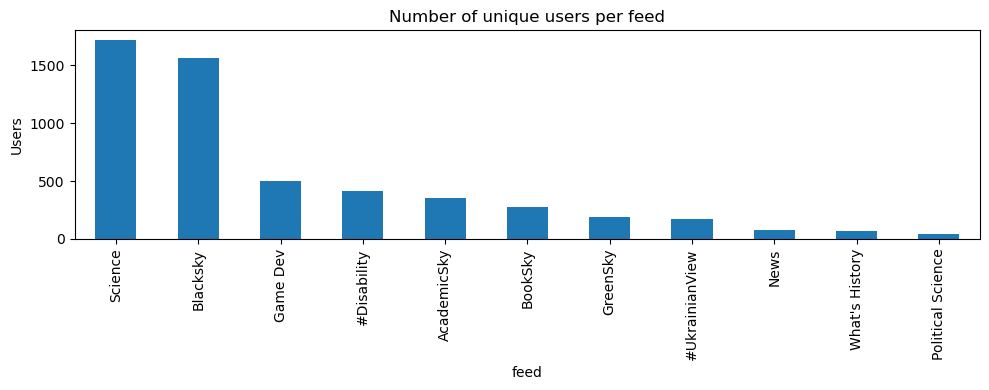

In [84]:
posts_per_feed.plot(
    kind="bar",
    figsize=(10, 4),
    title="Number of posts per feed"
)
plt.ylabel("Posts")
plt.tight_layout()
plt.show()

users_per_feed.plot(
    kind="bar",
    figsize=(10, 4),
    title="Number of unique users per feed"
)
plt.ylabel("Users")
plt.tight_layout()
plt.show()


## Language tags (`langs`)

The `langs` column is a **list**, so one post can contribute to more than one language tag.  
To summarize languages per feed, we:

1) **explode** `langs` (one row per language tag),  
2) count `(feed, langs)` pairs, and  
3) convert counts to a **within-feed share**.

Below is a sample of the resulting table (counts + shares). In the feeds shown in the table, the top languages are:

- **#Disability:** `eng` 95.85%; `jpn` 2.53%; `deu` 1.08%
- **#UkrainianView:** `eng` 53.39%; `ukr` 41.76%; `ibo` 2.61%
- **AcademicSky:** `eng` 96.92%; `deu` 1.23%; `fra` 0.86%


In [85]:
langs_long = (
    df_all[["feed", "langs"]]
    .dropna(subset=["langs"])
    .explode("langs")
)

lang_share = (
    langs_long
    .groupby(["feed", "langs"])
    .size()
    .reset_index(name="count")
)

lang_share["share"] = lang_share["count"] / lang_share.groupby("feed")["count"].transform("sum")
lang_share = lang_share.sort_values(["feed", "share"], ascending=[True, False])

lang_share.head(20)


,feed,langs,count,share
1,#Disability,eng,531,0.958484
3,#Disability,jpn,14,0.025271
0,#Disability,deu,6,0.010830
2,#Disability,fra,2,0.003610
4,#Disability,swe,1,0.001805
8,#UkrainianView,eng,1455,0.533945
14,#UkrainianView,ukr,1138,0.417615
10,#UkrainianView,ibo,71,0.026055
13,#UkrainianView,rus,23,0.008440
7,#UkrainianView,deu,19,0.006972


### Top languages per feed (bar charts)

Next we take the same `(feed, langs)` share table and, for each feed, plot the **top 5 language tags** by share.


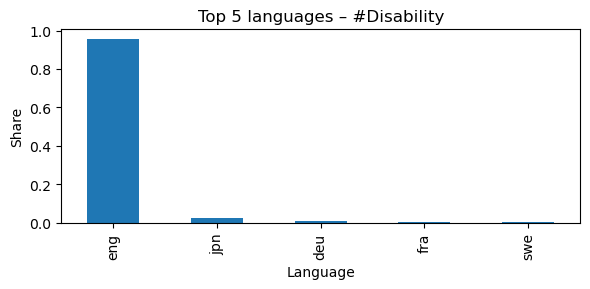

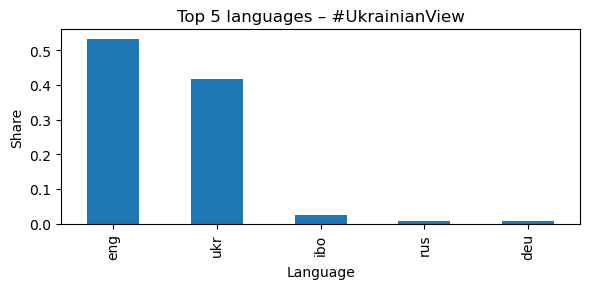

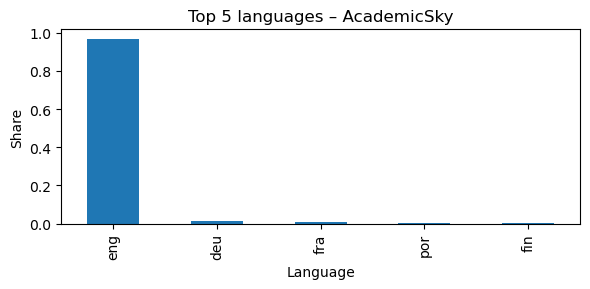

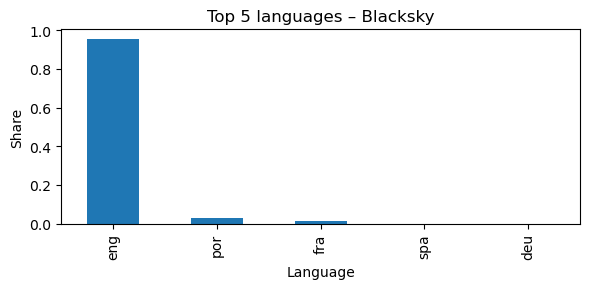

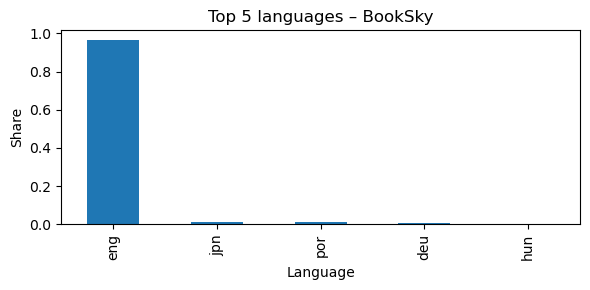

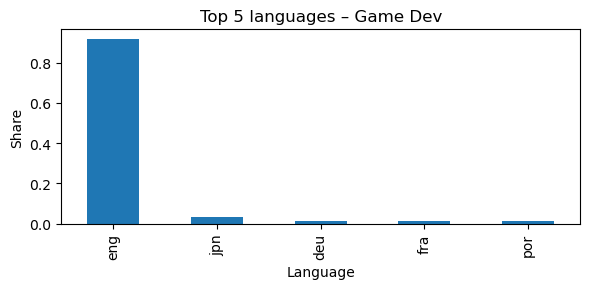

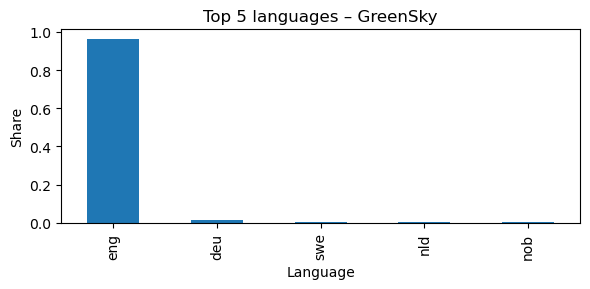

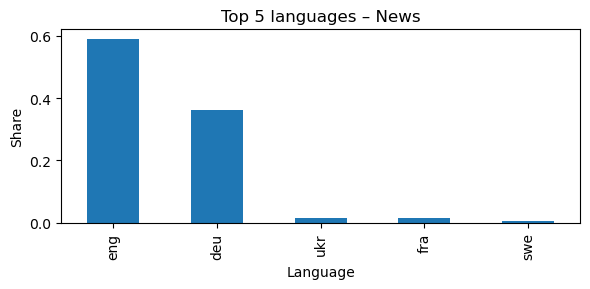

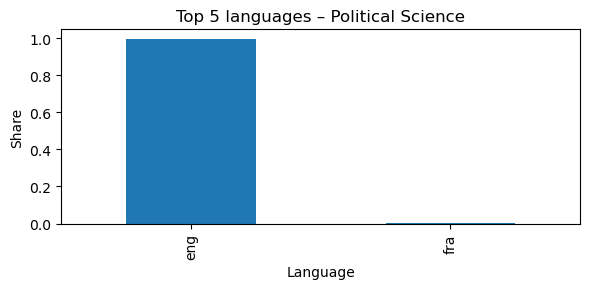

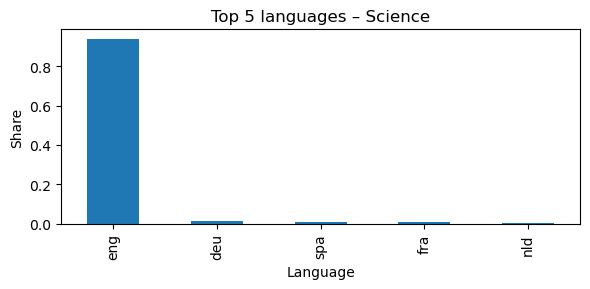

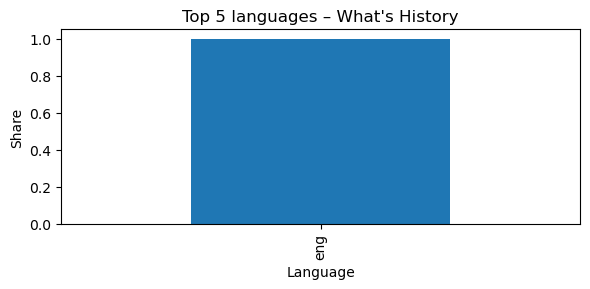

In [86]:
topk = 5
top_langs = (
    lang_share.sort_values(["feed", "share"], ascending=[True, False])
    .groupby("feed")
    .head(topk)
)

for feed_name, g in top_langs.groupby("feed"):
    g = g.sort_values("share", ascending=False)
    g.set_index("langs")["share"].plot(kind="bar", figsize=(6, 3), title=f"Top {topk} languages – {feed_name}")
    plt.ylabel("Share")
    plt.xlabel("Language")
    plt.tight_layout()
    plt.show()


### English share across feeds

Here we isolate `langs == "eng"` and plot, for each feed, the share of posts tagged as English (again: after exploding `langs`, then normalizing within feed).


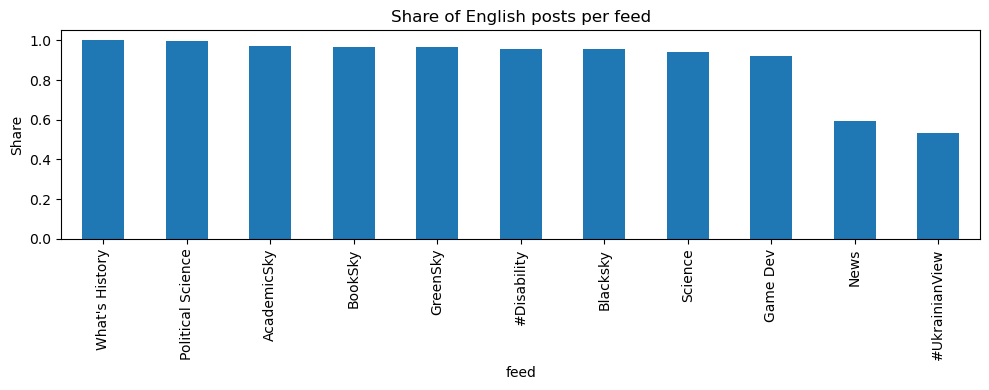

In [87]:
eng_share = (
    lang_share[lang_share["langs"] == "eng"]
    .set_index("feed")["share"]
    .sort_values(ascending=False)
)

eng_share.plot(kind="bar", figsize=(10, 4), title="Share of English posts per feed")
plt.ylabel("Share")
plt.tight_layout()
plt.show()


## Post length (approximate word counts)

Bluesky posts vary a lot in style: some are short reactions, some are long text posts, and some are basically links.

To quantify this, we compute an approximate `word_count` from `text` by splitting on whitespace.
This is not “linguistically perfect”, but it’s a consistent, transparent proxy for how much text is there.


In [88]:
df_all["text"] = df_all["text"].fillna("")
df_all["word_count"] = df_all["text"].str.split().str.len()


### Summary table: mean / median / 75th percentile word counts

This table reports, per feed, the **mean**, **median (50%)**, and **75th percentile (75%)** of `word_count`.

In this sample, the longest feeds by mean word count are:

- **#Disability:** mean 33.72, median 35, 75% 46
- **GreenSky:** mean 31.44, median 32, 75% 43
- **Game Dev:** mean 30.24, median 30, 75% 42

And the shortest are:

- **Political Science:** mean 12.31, median 1, 75% 21
- **Blacksky:** mean 20.52, median 16, 75% 31
- **News:** mean 22.13, median 22, 75% 29


In [89]:
df_all.groupby("feed")["word_count"].describe()[["mean", "50%", "75%"]]


,mean,50%,75%
feed,,,
#Disability,33.720848,35.0,46.0
#UkrainianView,29.610105,32.0,44.0
AcademicSky,27.319825,29.0,38.0
Blacksky,20.515239,16.0,31.0
BookSky,27.990596,28.0,41.0
Game Dev,30.244094,30.0,42.0
GreenSky,31.438066,32.0,43.0
News,22.126567,22.0,29.0
Political Science,12.305322,1.0,21.0


### Distribution of post length per feed (boxplot)

To complement the summary table, we visualize the **distribution** of `word_count` per feed.  
This is the same metric as above, just shown as a distribution rather than three summary numbers.


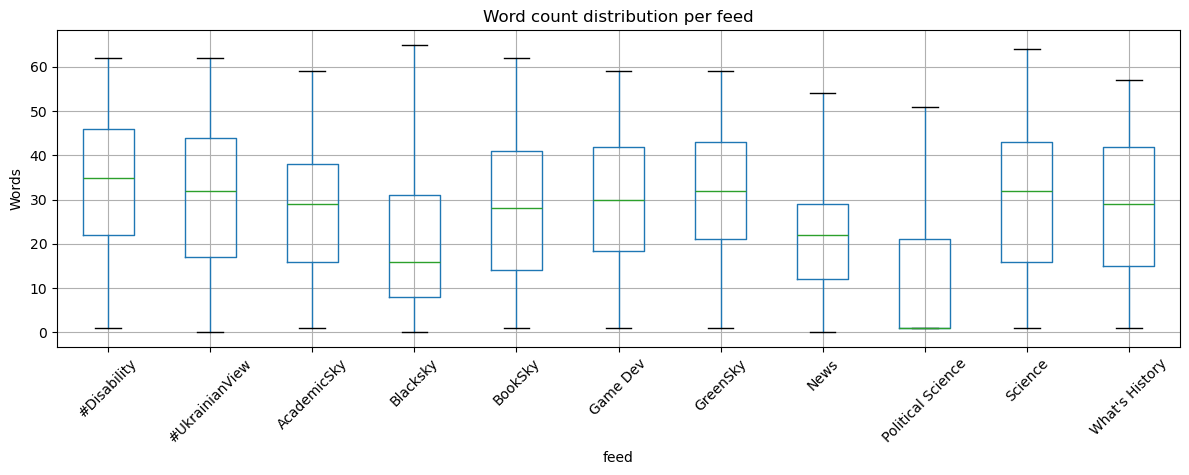

In [90]:
df_all.boxplot(
    column="word_count",
    by="feed",
    figsize=(12, 5),
    showfliers=False
)

plt.title("Word count distribution per feed")
plt.suptitle("")
plt.ylabel("Words")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Engagement (`like_count`, `repost_count`, `reply_count`)

We summarize engagement in two complementary ways:

1) **Mean engagement per feed** (`groupby("feed").mean()`): average likes, reposts, and replies.

2) **Zero-rate per feed**: the share of posts where a given counter is exactly 0 (e.g., fraction of posts with `like_count == 0`).

How to interpret these:

- Social engagement is usually **skewed**: lots of zeros, a few viral posts.
  - That means **means can be pulled up** by outliers.
  - Zero-rates help ground the story (“how often does anything happen at all?”).
- Differences across feeds can reflect both **topic** (some topics invite discussion) and **audience size** (bigger communities create more engagement opportunity).


### Mean engagement per feed (table)

This table is `df_all.groupby("feed")[["like_count","repost_count","reply_count"]].mean()`.

In this sample:
- Highest **mean likes**: **News** (43.18)
- Highest **mean reposts**: **#UkrainianView** (6.47)
- Highest **mean replies**: **Political Science** (1.67)


In [91]:
df_all.groupby("feed")[["like_count", "repost_count", "reply_count"]].mean()


,like_count,repost_count,reply_count
feed,,,
#Disability,8.404594,2.574205,0.657244
#UkrainianView,25.111535,6.472831,0.955672
AcademicSky,4.661555,1.325301,0.444688
Blacksky,20.103526,3.731541,1.292392
BookSky,6.310345,1.526646,0.584639
Game Dev,6.848819,1.047244,0.505512
GreenSky,12.771903,3.889728,0.965257
News,43.180020,5.244538,1.619681
Political Science,10.672269,2.571429,1.672269


### How often engagement is zero (table)

This table computes the share of posts with **0 likes**, **0 reposts**, and **0 replies** per feed.

In this sample:
- Lowest **zero-like** rate (i.e., likes are almost never 0): **#UkrainianView** (0.43%)
- Highest **zero-like** rate: **AcademicSky** (26.51%)
- Lowest **zero-repost** rate: **#UkrainianView** (18.49%)
- Highest **zero-repost** rate: **Game Dev** (69.76%)
- Lowest **zero-reply** rate: **GreenSky** (47.58%)
- Highest **zero-reply** rate: **AcademicSky** (72.40%)


In [92]:
(df_all[["like_count", "repost_count", "reply_count"]] == 0).groupby(df_all["feed"]).mean()


,like_count,repost_count,reply_count
feed,,,
#Disability,0.167845,0.565371,0.653710
#UkrainianView,0.004290,0.184938,0.510963
AcademicSky,0.265060,0.591457,0.723987
Blacksky,0.140594,0.611296,0.561198
BookSky,0.064263,0.626959,0.667712
Game Dev,0.201575,0.697638,0.675591
GreenSky,0.114804,0.489426,0.475831
News,0.135828,0.436289,0.702199
Political Science,0.033613,0.431373,0.565826


## Replies vs original posts

Two related checks:

- `reply_count` tells us how many replies a post received (an engagement signal).
- `reply_to` tells us whether *this post itself* is a reply (a structure / conversation signal).

We look at both by feed.


### Replies received per post (boxplot)

This plot summarizes the distribution of `reply_count` per feed - i.e., how many replies posts receive in each feed sample.


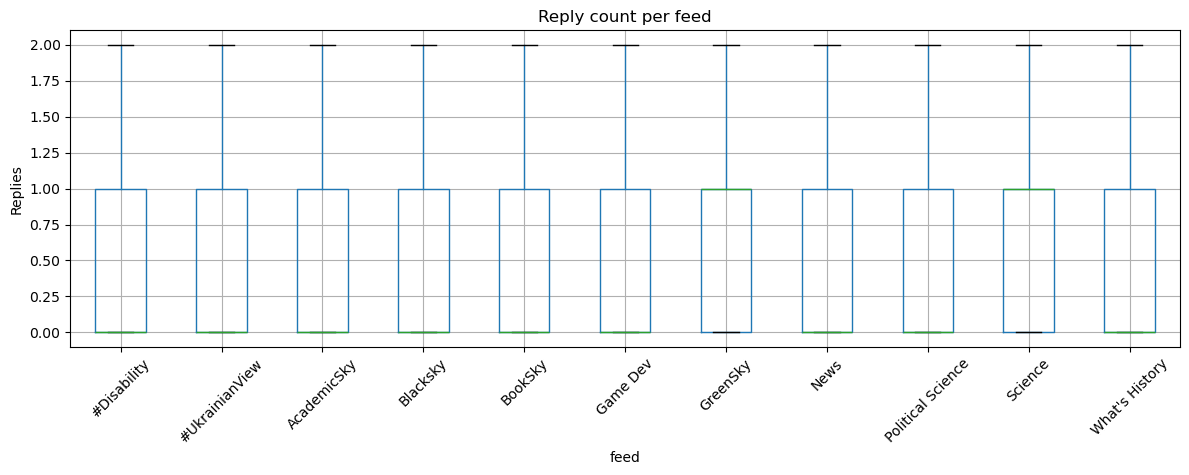

In [93]:
df_all.boxplot(
    column="reply_count",
    by="feed",
    figsize=(12, 5),
    showfliers=False
)

plt.title("Reply count per feed")
plt.suptitle("")
plt.ylabel("Replies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [94]:
df_all["is_reply"] = df_all["reply_to"].notna()

reply_share = (
    df_all.groupby("feed")["is_reply"]
    .mean()
    .sort_values(ascending=False)
)


### Share of posts that are replies (bar chart)

Here we create `is_reply = reply_to.notna()` and then take the **mean of `is_reply` per feed**.  
That mean is exactly the **fraction of posts that are replies** in each feed sample.


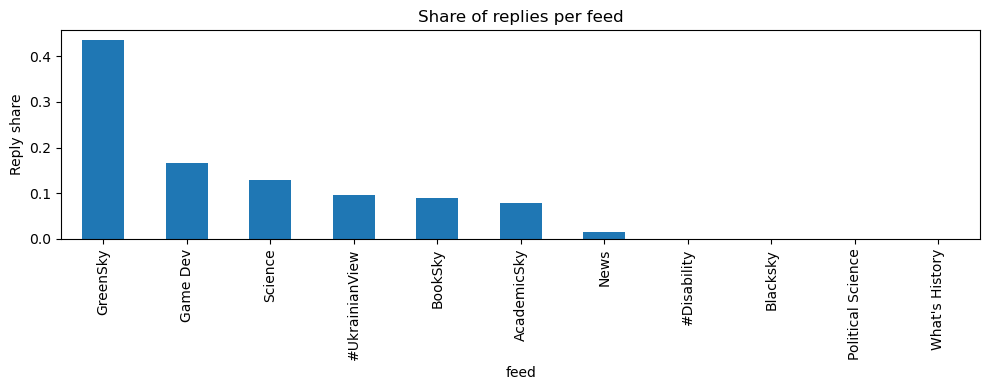

In [95]:
reply_share.plot(
    kind="bar",
    figsize=(10, 4),
    title="Share of replies per feed"
)

plt.ylabel("Reply share")
plt.tight_layout()
plt.show()


## Time coverage and activity

Before plotting “activity over time”, we verify the actual date span present in the sample, and we check how many `date` values are missing.

This matters because gaps or missing timestamps can create fake “dips” in daily counts.


In [96]:
df_all["date"].min(), df_all["date"].max()

(Timestamp('2023-02-20 02:27:00'), Timestamp('2024-03-18 23:59:00'))

### Date span and missing timestamps

This cell prints the min/max `date` and the fraction of missing `date` values in `df_all`.


min/max date: 2023-02-20 02:27:00 2024-03-18 23:59:00
missing dates: 0.0


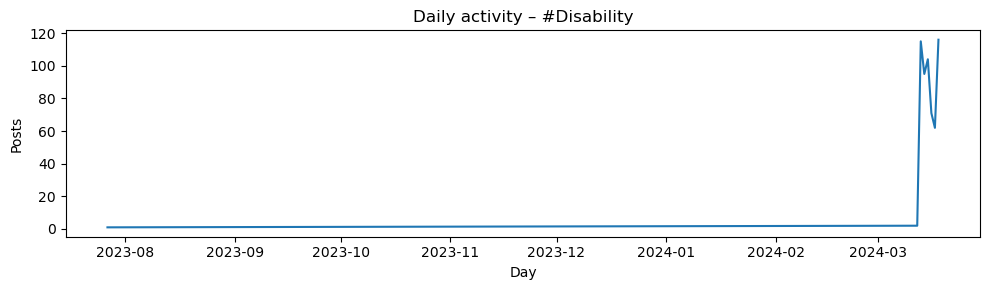

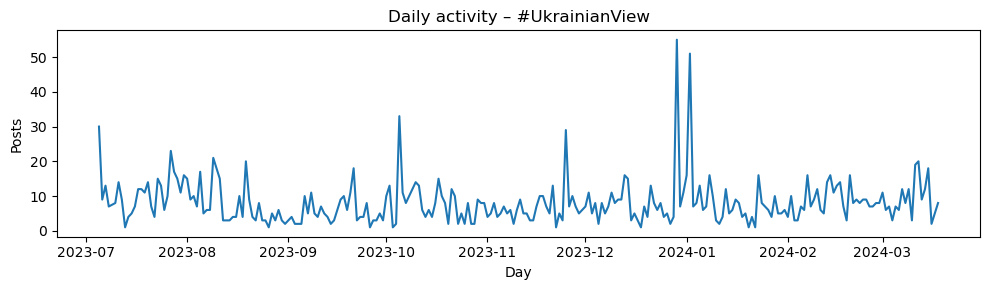

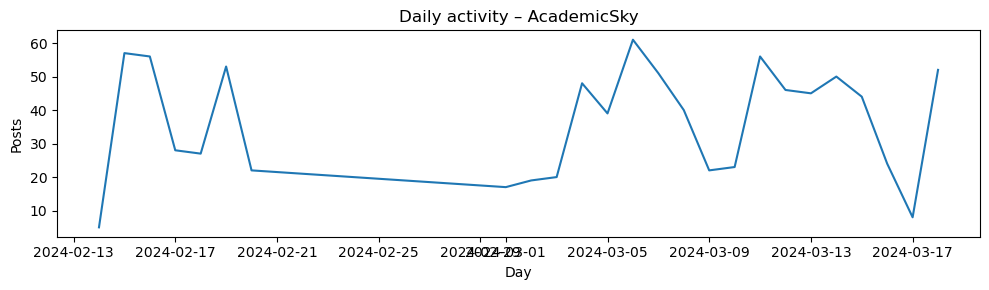

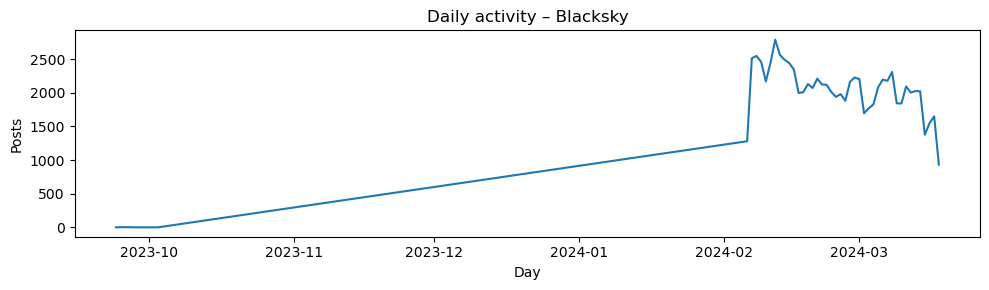

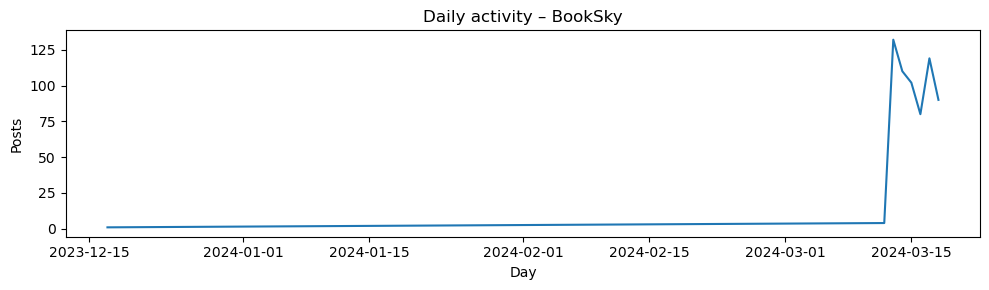

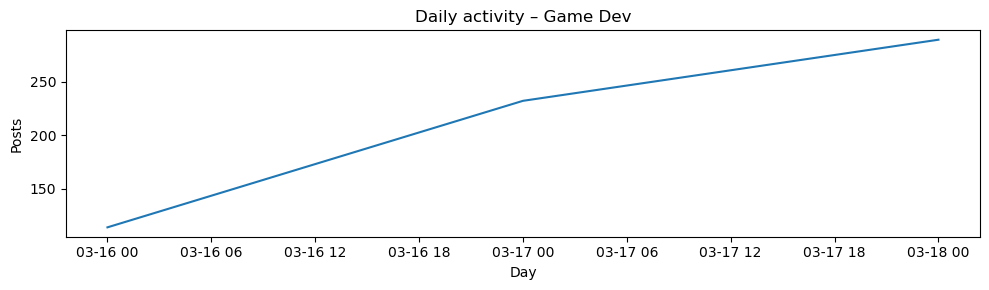

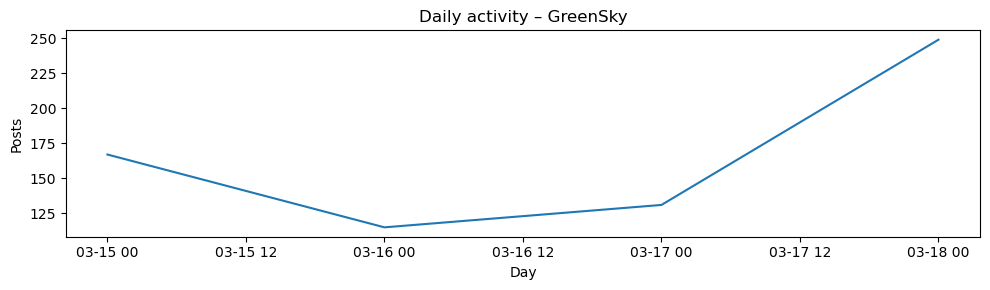

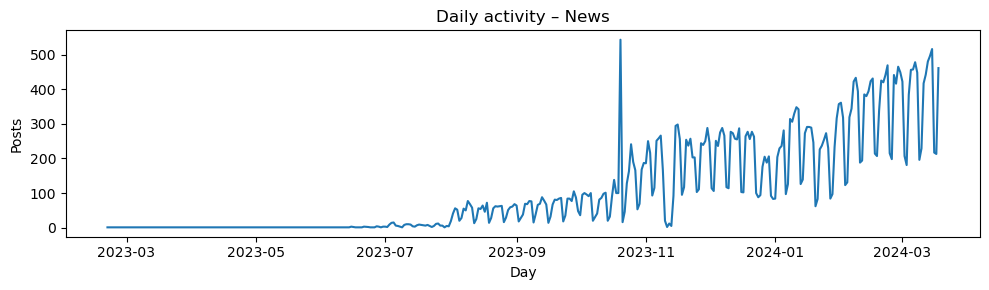

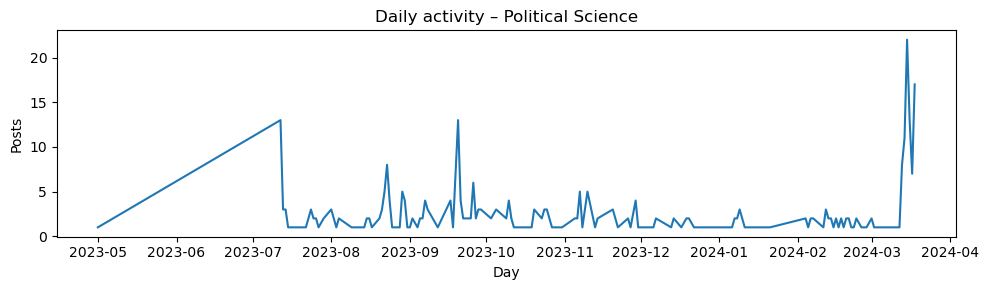

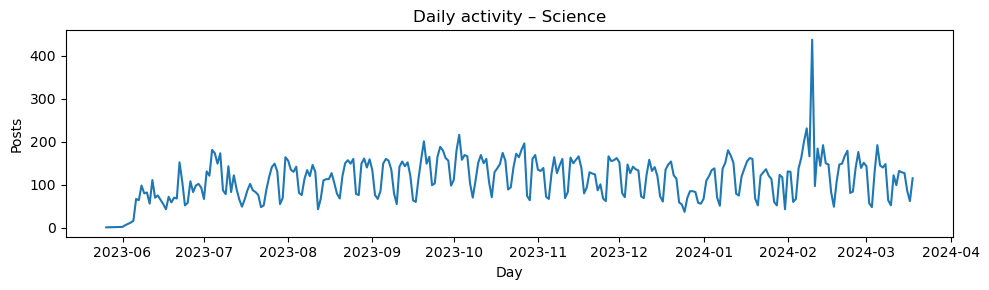

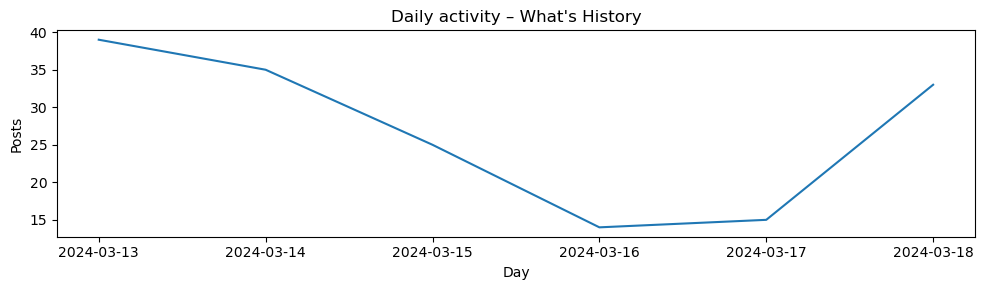

In [97]:
print("min/max date:", df_all["date"].min(), df_all["date"].max())
print("missing dates:", df_all["date"].isna().mean())

# agregacja dzienna
df_all["day"] = df_all["date"].dt.date
daily_feed = (
    df_all
    .groupby(["feed", "day"])
    .size()
    .reset_index(name="posts")
)

# wykresy – osobny dla każdego feedu
feeds = sorted(daily_feed["feed"].unique())

for feed in feeds:
    s = (
        daily_feed[daily_feed["feed"] == feed]
        .set_index("day")["posts"]
        .sort_index()
    )

    s.plot(figsize=(10, 3), title=f"Daily activity – {feed}")
    plt.xlabel("Day")
    plt.ylabel("Posts")
    plt.tight_layout()
    plt.show()
